# Bayesian Optimization: Example Application

Here we demonstrate how to use BOtorch. 

In [1]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import UpperConfidenceBound
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.models.transforms import Standardize

# set datatype to double
torch.set_default_dtype(torch.float64)

# fix random seed for reproducibility
torch.manual_seed(42)



First, you need some kind of experiment function that either runs a simulation, or does the data exchage with the real system.
It should have the parameters as an input and return the cost function as a result of the experiment. 

In this example, we give the experiment the normalized input parameters und transform them to the real bounds in the function. 
This has the advantage, that later in the BO loop we only need to deal with parameters in the unit cube. 


In [2]:
def experiment(parameters_normalized):
    """
    This function simulates an experiment with the given parameters.
    It computes a result based on the parameters provided.
    The parameters are expected to be a tensor of shape (N, 3), where N is the number of parameter sets.
    """
    # Denormalize parameters
    parameters = parameters_normalized * torch.tensor([5.0, 5.0, 5.0])  # Shape: (N, 3)
    
    # Calculate the result for each parameter set
    results = 30 - ((parameters[:, 0] - 2)**2 + (parameters[:, 1] - 3)**2 + 
                    (parameters[:, 2] - 4)**2 + 10 * torch.sin(parameters[:, 0]) * 
                    torch.cos(parameters[:, 1]) * torch.sin(parameters[:, 2]))
    
    # Add noise
    noise = torch.normal(mean=0.0, std=0.1, size=results.shape)  # Noise shape matches results shape
    results += noise
    
    return results



Here is the example code for the BO-loop. 
We have one function that fits the GP model to the current data set. 

In [3]:
def initialize_model(X_train, Y_train):
    """
    This function initializes the model with the training data.
    It should return a BoTorch model.
    """
    model = SingleTaskGP(X_train, Y_train, outcome_transform=Standardize(m=1)) # Standardize the y-values
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model

In the BO-loop itself, we first define our number of experiments. Then we collect initial 3 initial data points. 
After that we run BO and first, update the model and intitialize the acquisition function. 
With optimize_acqf, we find the next parameters to evalute and perform an experiment with these parameters. 
Finally, we add these parameters and the experiment results to the data set and loop. 

In [8]:

def bo_loop():
    """ This function runs the Bayesian optimization loop.
    It initializes the model, runs the optimization iterations,
    and collects the results.
    """
    
    iterations = 30
    unit_cube = torch.tensor([[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]], dtype=torch.float64)
    # collect initial data
    X_train = torch.rand(3, 3, dtype=torch.float64)  # initial random parameters in the unit cube
    Y_train = experiment(X_train)

    for i in range(iterations):
        # update GP model with the training data
        model = initialize_model(X_train, Y_train.unsqueeze(-1))
        
        # define the acquisition function
        UCB = UpperConfidenceBound(model, beta=2, maximize=True)
        # find the next parameters to evaluate
        next_parameters, _ = optimize_acqf(UCB, bounds=unit_cube, q=1, num_restarts=10, raw_samples=255)
        # run the experiment with the next parameters
        next_result = experiment(next_parameters)

        # append the new data to the training set
        X_train = torch.cat((X_train, next_parameters), dim=0)
        Y_train = torch.cat((Y_train, next_result), dim=0)
        #print(f"Iteration {i + 1}: Next parameters: {next_parameters}, Result: {next_result}")
    return X_train, Y_train

x, y = bo_loop()


Plot the results in comparison to random search. 

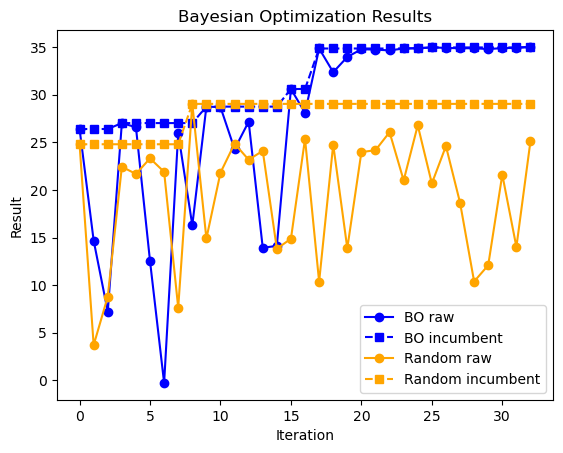

In [9]:
def plot(X_train, Y_train, color='blue', label='BO'):
    # plot best parameters over iterations
    import matplotlib.pyplot as plt
    incumbents = Y_train.cummax(dim=0).values
    plt.plot(Y_train, 'o-', label=f'{label} raw', color=color)
    plt.plot(incumbents, 's--', label=f'{label} incumbent', color=color)
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Result')
    plt.title('Bayesian Optimization Results')

plot(x, y, "blue", 'BO')
# compare to random
x_random = torch.rand(33, 3, dtype=torch.float64)
y_random = experiment(x_random.squeeze(0))
plot(x_random, y_random, "orange", 'Random')